In [1]:
import math
import pandas as pd
import numpy as np
from mpi4py import MPI
import os


# from kulfan import Kulfan
from ada.geometry.airfoils.kulfan import Kulfan

st = pd.ExcelFile('IEA-22-280-RWT_tabular.xlsx')

# ========================================================
# Load blade geometry parameters
# ========================================================
blade_geometry = pd.read_excel(st, 'Blade Geometry')

airfoils = blade_geometry.iloc[0:16]
airfoil_spans = airfoils['Spanwise position [r/R]'].to_numpy()
airfoil_names = airfoils['Airfoil name'].to_list()

detailed_geometry = blade_geometry.iloc[19:]
normSpans = detailed_geometry['Spanwise position [r/R]'].to_numpy()
chords    = detailed_geometry['Airfoil name'].to_numpy()
twists    = detailed_geometry['Unnamed: 2'].to_numpy()*180.0/np.pi
pas       = detailed_geometry['Unnamed: 3'].to_numpy()
spans     = detailed_geometry['Unnamed: 4'].to_numpy()
prebends  = detailed_geometry['Unnamed: 5'].to_numpy()
sweeps    = detailed_geometry['Unnamed: 6'].to_numpy()

# ========================================================
# Load airfoils
# ========================================================
airfoil_data = {}
for st_nm in st.sheet_names:
    if 'Airfoil ' in st_nm:
        coordinates = []
        nm = st_nm.replace('Airfoil ','')
        # print(nm)
        airfoil_sheet = pd.read_excel(st, st_nm)
        coordinates_end = 0
        for i in range(4,1000):
            coordinates_end = i
            rw = airfoil_sheet.iloc[i].to_numpy()
            if math.isnan(rw[0]):
                break
            else:
                coordinates.append([rw[0], rw[1]])
                
        coordinates = np.array(coordinates)
        coordinates[:,0] -= min(coordinates[:,0])
        airfoil_data[nm] = {}
        airfoil_data[nm]['coordinates'] = coordinates
        # plt.plot(coordinates[:,0], coordinates[:,1])
        # plt.axis('equal')
        
        airfoil_data[nm]['data'] = []
        currentDataStack = []
        for i in range(coordinates_end, len(airfoil_sheet)):
            rw = airfoil_sheet.iloc[i].to_numpy().tolist()
            if i == len(airfoil_sheet)-1:
                currentDataStack.append(rw)
                rw = ['alpha',0,0]
            
            if isinstance(rw[0], (float, int)):
                if not math.isnan(rw[0]):
                    currentDataStack.append(rw)
            elif isinstance(rw[0],str):
                if 'alpha' in rw[0]:
                    if len(currentDataStack)!=0:
                        dta = np.array(currentDataStack)
                        packedData = {'alpha':dta[:,0]*180.0/np.pi, 'cl':dta[:,1], 'cd':dta[:,2], 'cm':dta[:,3]}
                        airfoil_data[nm]['data'].append(packedData)
                        currentDataStack = []
                else:
                    # do nothing
                    assert('alpha' not in rw[0])
                    assert(isinstance(rw[0],str))

            else:
                assert(math.isnan(rw[0]) or rw[0]=='Reynolds')
        

[Codys-Air:35483] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Codys-Air.501/jf.0/2812084224/sm_segment.Codys-Air.501.a79d0000.0 could be created.


In [2]:
# ========================================================
# Make the Kulfan objects
# ========================================================
for nm, afl in airfoil_data.items():
    kfl = Kulfan()
    kfl.fit2coordinates(afl['coordinates'][:,0], afl['coordinates'][:,1], fit_order=10)
    airfoil_data[nm]['kulfan'] = kfl

# fls = os.listdir('./oso1')
# fls = list(sorted([f for f in fls if '.dat' in f]))
# for f in fls:
#     kfl = Kulfan()
#     kfl.fit2file('./oso1/'+f)
#     airfoil_data['oso-1-%s'%(f[-6:-4])] = {}
#     airfoil_data['oso-1-%s'%(f[-6:-4])]['kulfan'] = kfl

# airfoil_names[9]  = 'oso-1-36' 
# airfoil_names[10] = 'oso-1-33' 
# airfoil_names[11] = 'oso-1-30' 
# airfoil_names[12] = 'oso-1-27' 
# airfoil_names[13] = 'oso-1-24' 
# airfoil_names[14] = 'oso-1-21' 
# airfoil_names[15] = 'oso-1-21' 

In [3]:
# ========================================================
# Stack all the detailed airfoils
# ========================================================
esp_string = 'mark \n'

circle_string = ''
theta = 25 * np.pi/180.0
circle_string += 'skbeg %f %f 0 \n'%(np.cos(theta), np.sin(theta))
circle_string += 'cirarc 0  1 0 -1 0 0 \n'
circle_string += 'cirarc 0 -1 0 %f %f 0 \n'%(np.cos(theta), -1*np.sin(theta))
circle_string += 'cirarc 1 0 0 %f %f 0 \n'%(np.cos(theta), np.sin(theta))
circle_string += 'skend \n'
circle_string += 'scale 0.5 \n'
circle_string += 'translate 0.5 0 0 \n'

# FB80 has a larger TE gap than FB90, which leads to significant blending issues
# this is in a region where flow is slow
airfoil_data['FB90']['kulfan'].constants.TE_gap *= 1.3

for i in range(0,len(normSpans)):
    normSpan = normSpans[i]
    chord    = chords[i]
    twist    = twists[i]
    pa       = pas[i]
    span     = spans[i]
    prebend  = prebends[i]
    sweep    = sweeps[i]
    
    if normSpan <= 0.02:
        esp_string += circle_string

    elif normSpan <= airfoil_spans[2]:
        esp_string += airfoil_data['FB90']['kulfan'].toESP()
        
    else:

        if normSpan != 1:
            right_airfoil_index = np.argmax(airfoil_spans>normSpan)
            left_airfoil_index  = right_airfoil_index - 1
        else:
            right_airfoil_index = -1
            left_airfoil_index  = -1
            
        interval_length = airfoil_spans[right_airfoil_index] - airfoil_spans[left_airfoil_index]
        if interval_length == 0:
            progres_frac = 1
        else:    
            progress_frac = (normSpan - airfoil_spans[left_airfoil_index]) / interval_length
        
        xcoords_left  = airfoil_data[airfoil_names[left_airfoil_index]]['kulfan'].xcoordinates
        xcoords_right = airfoil_data[airfoil_names[right_airfoil_index]]['kulfan'].xcoordinates
        ycoords_left  = airfoil_data[airfoil_names[left_airfoil_index]]['kulfan'].ycoordinates
        ycoords_right = airfoil_data[airfoil_names[right_airfoil_index]]['kulfan'].ycoordinates
        xcoords = (1-progress_frac)*xcoords_left + progress_frac*xcoords_right
        ycoords = (1-progress_frac)*ycoords_left + progress_frac*ycoords_right
        
        kfl = Kulfan()
        kfl.fit2coordinates(xcoords, ycoords)
        esp_string += kfl.toESP()
            
        
    esp_string += 'translate %f 0 0 \n'%(-1*pa)
    esp_string += 'scale %f \n'%(chord)
    esp_string += 'rotatez %f 0 0 \n'%(twist)
    esp_string += 'translate 0 %f %f \n'%(-prebend,span)
    esp_string += '\n'

esp_string += "dimension custom 1 3 0\n"
esp_string += 'set custom "0.040;0.650;0.970"\n'
# esp_string += "rule 1 \n"
esp_string += "blend 1 \n"
# esp_string += "attribute _color custom\n"
esp_string += 'store blade \n'
esp_string += 'restore blade \n'
esp_string += 'box -10 -10 -10 20 20 %f \n'%(0.196653366 * 137.8)
esp_string += 'intersect \n'
esp_string += "attribute _color $yellow\n"
esp_string += 'store root \n'
# esp_string += 'restore blade \n'
# esp_string += 'box -10 -10 -10 20 20 %f \n'%(0.196653366 * 137.8)
# esp_string += 'subtract \n'
# esp_string += 'restore root\n'

# ========================================================
# Stack all the detailed airfoils
# ========================================================
esp_string += 'mark \n'

circle_string = ''
theta = 25 * np.pi/180.0
circle_string += 'skbeg %f %f 0 \n'%(np.cos(theta), np.sin(theta))
circle_string += 'cirarc 0  1 0 -1 0 0 \n'
circle_string += 'cirarc 0 -1 0 %f %f 0 \n'%(np.cos(theta), -1*np.sin(theta))
circle_string += 'cirarc 1 0 0 %f %f 0 \n'%(np.cos(theta), np.sin(theta))
circle_string += 'skend \n'
circle_string += 'scale 0.5 \n'
circle_string += 'translate 0.5 0 0 \n'

# FB80 has a larger TE gap than FB90, which leads to significant blending issues
# this is in a region where flow is slow
# airfoil_data['FB90']['kulfan'].constants.TE_gap *= 1.3

for i in range(0,len(normSpans)):
    normSpan = normSpans[i]
    chord    = chords[i]
    twist    = twists[i]
    pa       = pas[i]
    span     = spans[i]
    prebend  = prebends[i]
    sweep    = sweeps[i]
    
    if normSpan <= 0.02:
        esp_string += circle_string

    elif normSpan <= airfoil_spans[2]:
        esp_string += airfoil_data['FB90']['kulfan'].toESP()
        
    else:

        if normSpan != 1:
            right_airfoil_index = np.argmax(airfoil_spans>normSpan)
            left_airfoil_index  = right_airfoil_index - 1
        else:
            right_airfoil_index = -1
            left_airfoil_index  = -1
            
        interval_length = airfoil_spans[right_airfoil_index] - airfoil_spans[left_airfoil_index]
        if interval_length == 0:
            progres_frac = 1
        else:    
            progress_frac = (normSpan - airfoil_spans[left_airfoil_index]) / interval_length
        
        xcoords_left  = airfoil_data[airfoil_names[left_airfoil_index]]['kulfan'].xcoordinates
        xcoords_right = airfoil_data[airfoil_names[right_airfoil_index]]['kulfan'].xcoordinates
        ycoords_left  = airfoil_data[airfoil_names[left_airfoil_index]]['kulfan'].ycoordinates
        ycoords_right = airfoil_data[airfoil_names[right_airfoil_index]]['kulfan'].ycoordinates
        xcoords = (1-progress_frac)*xcoords_left + progress_frac*xcoords_right
        ycoords = (1-progress_frac)*ycoords_left + progress_frac*ycoords_right
        
        kfl = Kulfan()
        kfl.fit2coordinates(xcoords, ycoords)
        esp_string += kfl.toESP()
        
    esp_string += 'translate %f 0 0 \n'%(-1*pa)
    esp_string += 'scale %f \n'%(chord)
    esp_string += 'rotatez %f 0 0 \n'%(twist)
    esp_string += 'translate 0 %f %f \n'%(-prebend,span)
    esp_string += '\n'


esp_string += "dimension custom 1 3 0\n"
# esp_string += 'set custom "0.040;0.650;0.970"\n'
esp_string += 'set custom "0.040;0.970;0.650"\n'
# esp_string += "rule 1 \n"
esp_string += "blend 1 \n"
esp_string += "attribute _color custom\n"
esp_string += 'store blade \n'
# esp_string += 'restore blade \n'
# esp_string += 'box -10 -10 -10 20 20 %f \n'%(0.196653366 * 137.8)
# esp_string += 'intersect \n'
# esp_string += "attribute _color $yellow\n"
# esp_string += 'store root \n'
esp_string += 'restore blade \n'
esp_string += 'box -10 -10 -10 20 20 %f \n'%(0.196653366 * 137.8)
esp_string += 'subtract \n'
esp_string += 'restore root\n'





# # esp_string += 'blend 1 \n'
# esp_string += 'rule 1 \n'
# # esp_string += 'dimension tess_params 1 3 0 \n'
# # esp_string += 'set tess_params "1.0; 0.1; 10;" \n'
# # esp_string += 'store blade \n'
# # esp_string += 'restore blade \n'
# # esp_string += 'attribute .tParams tess_params \n'
# # esp_string += 'attribute .color blue \n'




f = open('22mw_test_fullDetail_og.csm','w')
f.write(esp_string)
f.close()

(-0.049999999999999996,
 1.0499999999999998,
 -0.1498785035554645,
 0.18044672794600333)

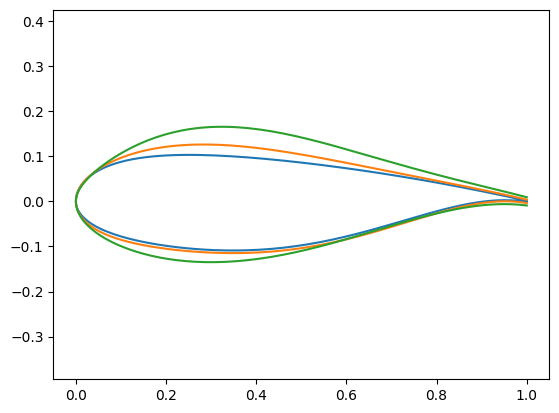

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from ada.geometry.airfoils.kulfan import Kulfan

te_gap_lookup = {
    '15':  0.00196,
    '18':  0.00230,
    '21':  0.00262,
    '24':  0.00751,
    '27':  0.01012,
    '30':  0.01828,
    '33':  0.02644,
    '36':  0.02896,
}

afl = Kulfan()

# # 21, Case 32
# afl.upperCoefficients = [3.743866053855737785e-01 ,-1.076908476462040181e-05 ,2.580628298219098671e-01, 6.891450569107820945e-02 ] 
# afl.lowerCoefficients = [-3.167134729632530288e-01, -3.382187087817455362e-01, -5.747763027851628959e-01, -5.079908121512190579e-10]

# 21, Case 33
afl = Kulfan(TE_gap=te_gap_lookup['21'])
afl.upperCoefficients = [3.372377933097095437e-01, 2.277576980903255610e-01, 2.292239493655851834e-01 ,2.233589442645467493e-01] 
afl.lowerCoefficients = [-2.815202448498445031e-01 ,-2.267801972401524979e-01 ,-4.662679055325549271e-01, 1.686188966548547719e-01]
plt.plot(afl.xcoordinates, afl.ycoordinates)

# # 21, Case 34
# afl.upperCoefficients = [3.579044599204145860e-01 ,6.052071365761685140e-05, 2.728288096114636074e-01, 1.166123137855449160e-01] 
# afl.lowerCoefficients = [-2.962979545242776513e-01,-3.999533445558731137e-01, -4.762280655225188952e-01, 2.088979268260936716e-05]

# # 24, Case 32
# afl.upperCoefficients = [3.674828962186141301e-01 ,7.651698660990322032e-02 ,1.464897572597489150e-01, 1.540407756751998869e-01] 
# afl.lowerCoefficients = [-3.211699832705148250e-01, -4.168162165328938573e-01 ,-6.987209040430636398e-01 ,3.773051193918374607e-05]

# 24, Case 33
afl = Kulfan(TE_gap=te_gap_lookup['24'])
afl.upperCoefficients = [3.282355323967039440e-01, 3.844100698203009037e-01, 1.949586887054248208e-01, 2.434229955022536029e-01] 
afl.lowerCoefficients = [-3.216267632880454586e-01,-2.059733038865222687e-01, -5.132810674391410366e-01, 1.729294583432299248e-01]
plt.plot(afl.xcoordinates, afl.ycoordinates)


# 30, Case 33
afl = Kulfan(TE_gap=te_gap_lookup['30'])
afl.upperCoefficients = [2.956334812140250512e-01, 6.125913446795535622e-01 ,2.326296245618557912e-01 ,2.733398088601805553e-01] 
afl.lowerCoefficients = [-3.344050853076677154e-01, -3.828695904247209625e-01 ,-3.402208259217140984e-01 ,1.201919726902921509e-01 ]
plt.plot(afl.xcoordinates, afl.ycoordinates)





# plt.plot(afl.xcoordinates, afl.ycoordinates)
plt.axis('equal')